In [7]:
import sys
sys.path.append("/eos/home-m/mhassans/.local/lib/python2.7/site-packages")
!echo $PYTHONPATH
import ROOT
import uproot # can also use root_pandas or root_numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.metrics import confusion_matrix
import itertools

/usr/local/lib/swan/extensions/:/cvmfs/sft.cern.ch/lcg/releases/condor/8.9.11-1f759/x86_64-centos7-gcc8-opt/lib/python3:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/itk:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/python:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages


In [9]:
import matplotlib
#font = {'size'   : 16}

#matplotlib.rc('font', **font)



def custom_cms_label(ax, label1, label2, year, lumi=35.9, energy=13, extra_label=''):
    plt.rcParams.update({'font.size': 24})
    ax.text(
        0, 1, r' $\mathbf{CMS}\ \mathit{'+label1+'}\ \mathit{'+label2+'}$',
        ha='left', va='bottom', transform=ax.transAxes,
    )
    ax.text(
       # 1, 1, r'2018, ${:.1f}\ \mathrm{{fb}}^{{-1}}$ ({:.0f} TeV)'.format(lumi, energy),
        1, 1, year + r' ({:.0f} TeV)'.format(energy),
        ha='right', va='bottom', transform=ax.transAxes,
    )
    # label on centre top of axes
    ax.text(
        0.5, 1, extra_label,
        ha='center', va='bottom', transform=ax.transAxes,
    )
    plt.rcParams.update({'font.size': 18})
    
def plot_confusion_matrix(y_test, y_pred, classes,
                    figname, year, w_test=None, normalise_by_col=False, normalise_by_row=False, title="",
                    cmap=plt.cm.Blues, y_title='True decay mode', x_title='Categorized decay mode'):

    if w_test is not None: cm = confusion_matrix(y_test, y_pred, sample_weight=w_test)
    else: cm = confusion_matrix(y_test, y_pred) 
    if normalise_by_col:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print ('Normalised efficiency confusion matrix')
    if normalise_by_row:
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
        print ('Normalised purity confusion matrix')
    else:
        print ('Non-normalised confusion matrix')

    print (cm)
    
    #fontsize=20
    SMALL_SIZE = 19
    MEDIUM_SIZE = 22
    BIGGER_SIZE = 29
    
    plt.figure(figsize=(12,10))
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    #plt.rcParams.update({'font.size': 8})
    #plt.title(title)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(label = title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    fmt = '.3f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='w' if cm[i, j] > thresh else 'k')

    plt.tight_layout(pad=1.4)
    #plt.rcParams.update({'font.size': 14})
    plt.ylabel(y_title)
    plt.xlabel(x_title)

    
    ax = plt.gca()
    custom_cms_label(ax, 'Simulation', 'Preliminary', year, lumi=59.7, energy=13, extra_label='')
    
    plt.savefig(figname)
    print ('Confusion matrix saved as {}'.format(figname))

    return None


def calc_conf_matrix(tree, year, MVAorHPS="MVA"):
    #df= tree.pandas.df(["gen_match_2","tauFlag_2","mva_dm_2","tau_decay_mode_2"])
    df = tree.arrays(["gen_match_2","tauFlag_2","mva_dm_2","tau_decay_mode_2"], library="pd")
    df= df.loc[df["gen_match_2"]==5]
    labels=["other","$\pi^\pm$","$\pi^\pm \pi^0$","$\pi^\pm 2\pi^0$","$3\pi^\pm$","$3\pi^\pm \pi^0$"]
    if (MVAorHPS=="MVA"):
        plot_confusion_matrix(df["tauFlag_2"], df["mva_dm_2"], labels,
                    'purtiy_MVA_DM_' + year, year, normalise_by_row=True, title="MVA DM - Purity")
        plot_confusion_matrix(df["tauFlag_2"], df["mva_dm_2"], labels,
                    'efficiency_MVA_DM_' + year, year, normalise_by_col=True, title="MVA DM - Efficiency")
    
    if (MVAorHPS=="HPS"):
        plot_confusion_matrix(df["tauFlag_2"], df["tau_decay_mode_2"], labels,
                    'purtiy_HPS_DM_' + year, year, normalise_by_row=True, title="HPS DM - Purity")
        plot_confusion_matrix(df["tauFlag_2"], df["tau_decay_mode_2"], labels,
                    'efficiency_HPS_DM_' + year, year, normalise_by_col=True, title="HPS DM - Efficiency")    

    #plot_confusion_matrix(df["tau_decay_mode_2"], df["mva_dm_2"], labels,
    #                'HPSvsMVA_NormalizedMVA_' + year, year, normalise_by_row=True,
    #                      title="Normalized by MVA DM: "+year, y_title ='HPS DM', x_title = 'MVA DM')
    #plot_confusion_matrix(df["tau_decay_mode_2"], df["mva_dm_2"], labels,
    #                'HPSvsMVA_NormalizedHPS_' + year, year, normalise_by_col=True,
    #                      title="Normalized by HPS DM: "+year, y_title ='HPS DM', x_title = 'MVA DM')
 
    



Normalised purity confusion matrix
[[2.20848057e-01 6.58476283e-02 6.79902298e-02 1.71468619e-01
  5.95185464e-02 1.37520010e-01]
 [1.35107046e-02 6.97194460e-01 5.80447172e-02 1.45010296e-02
  6.63159291e-04 3.20157616e-04]
 [2.83828726e-01 1.99385244e-01 6.77422183e-01 2.46015678e-01
  9.26212476e-03 1.70668637e-02]
 [2.29318229e-01 1.85285947e-02 1.81996200e-01 5.54742252e-01
  4.53158849e-03 1.15995567e-02]
 [1.06578674e-01 1.80703915e-02 7.05622012e-03 4.41260447e-03
  8.16890667e-01 1.35697574e-01]
 [1.45915610e-01 9.73681950e-04 7.49044905e-03 8.85981761e-03
  1.09133914e-01 6.97795838e-01]]
Confusion matrix saved as purtiy_MVA_DM_2018
Normalised efficiency confusion matrix
Non-normalised confusion matrix
[[8.79735045e-02 1.42786173e-01 3.37073070e-01 2.05112813e-01
  1.11467605e-01 1.15586835e-01]
 [2.95089037e-03 8.28927805e-01 1.57781838e-01 9.51094667e-03
  6.80974702e-04 1.47544519e-04]
 [2.67295674e-02 1.02215393e-01 7.93988539e-01 6.95741963e-02
  4.10094792e-03 3.3913566

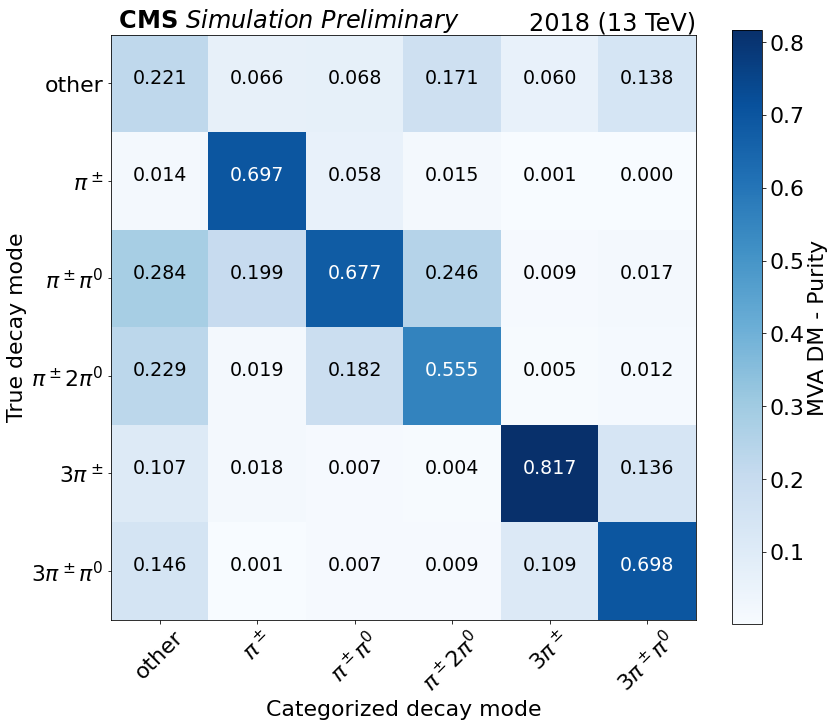

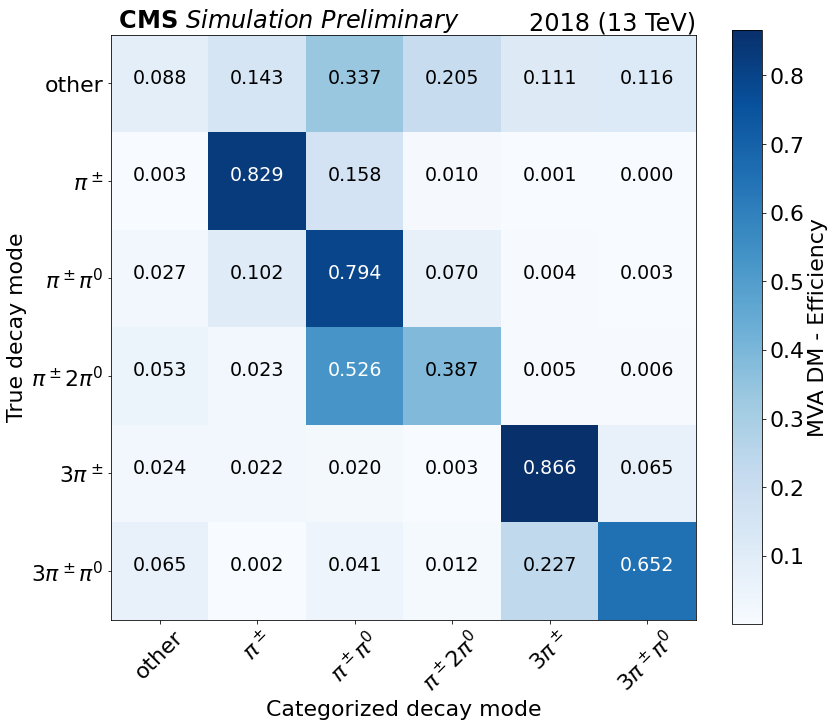

In [10]:
tree_2018= uproot.open("../Merged_ggH_VBF_HToTauTau_M-125_mt_2018.root")["ntuple"]
calc_conf_matrix(tree_2018, "2018", "MVA")

Normalised purity confusion matrix
[[2.24740069e-01 6.59348119e-02 6.79389248e-02 1.71007867e-01
  5.74298395e-02 1.38069739e-01]
 [1.05571848e-02 6.99884597e-01 6.08097693e-02 1.41930683e-02
  5.45043993e-04 2.04965284e-04]
 [2.77366036e-01 1.95215144e-01 6.78079024e-01 2.51825076e-01
  9.57720159e-03 1.64997054e-02]
 [2.35617169e-01 1.90851169e-02 1.78866871e-01 5.50535119e-01
  4.02665154e-03 1.11962286e-02]
 [1.06904825e-01 1.89396511e-02 7.23619984e-03 4.66014601e-03
  8.18389117e-01 1.27180959e-01]
 [1.44814716e-01 9.40679034e-04 7.06921061e-03 7.77872280e-03
  1.10032146e-01 7.06848403e-01]]
Confusion matrix saved as purtiy_MVA_DM_2017
Normalised efficiency confusion matrix
Non-normalised confusion matrix
[[8.95208563e-02 1.44401495e-01 3.36993458e-01 2.04974089e-01
  1.09655085e-01 1.14455017e-01]
 [2.26472068e-03 8.25479251e-01 1.62442238e-01 9.16182459e-03
  5.60461179e-04 9.15038660e-05]
 [2.60865641e-02 1.00946277e-01 7.94150833e-01 7.12691750e-02
  4.31767237e-03 3.2294785

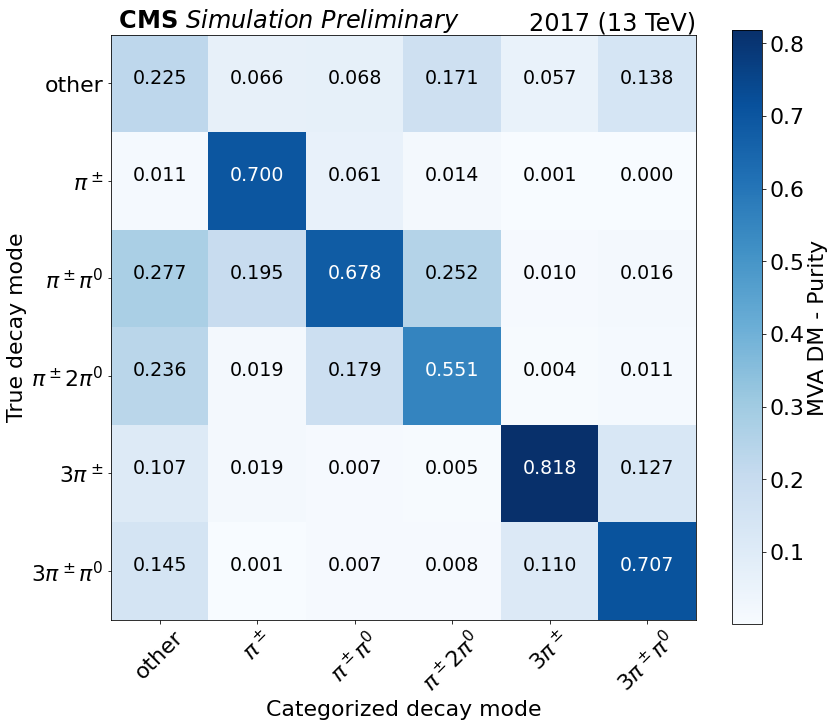

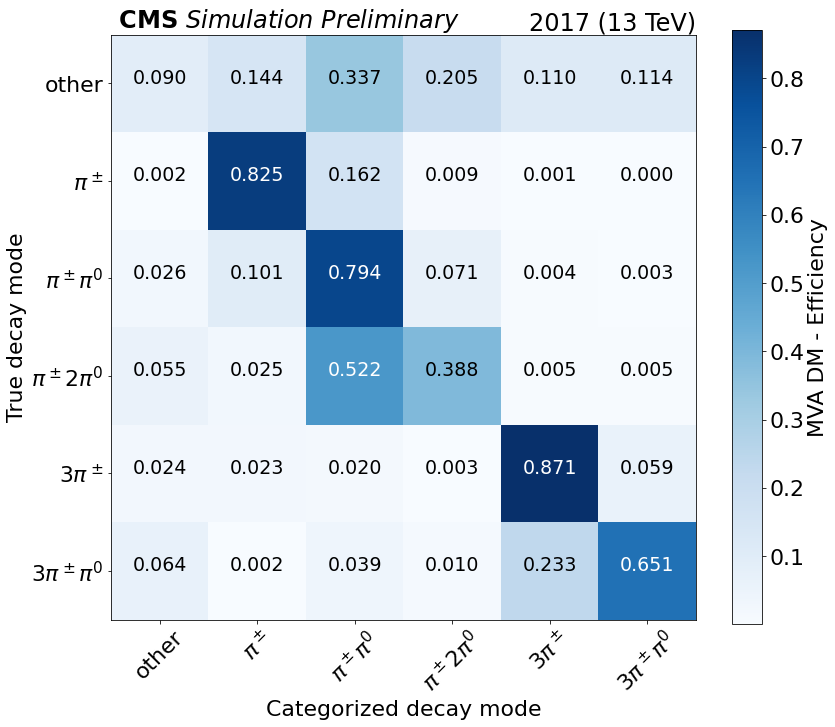

In [11]:
tree_2017= uproot.open("../Merged_ggH_VBF_HToTauTau_M-125_mt_2017.root")["ntuple"]
calc_conf_matrix(tree_2017, "2017", "MVA")

Normalised purity confusion matrix
[[2.31103523e-01 6.72152342e-02 7.11123870e-02 1.70679508e-01
  5.84429071e-02 1.31484335e-01]
 [1.53655130e-02 7.01739974e-01 6.27242716e-02 1.79909042e-02
  4.63325398e-04 1.97542570e-04]
 [2.55160639e-01 1.90966143e-01 6.71732453e-01 2.54793116e-01
  9.72983336e-03 1.56058631e-02]
 [2.07356821e-01 1.89080723e-02 1.76529353e-01 5.39704833e-01
  4.74509115e-03 1.10228754e-02]
 [1.32081329e-01 2.00258572e-02 9.14023252e-03 7.02247191e-03
  8.18648048e-01 1.51949745e-01]
 [1.58932174e-01 1.14471948e-03 8.76130329e-03 9.80916711e-03
  1.07970795e-01 6.89739639e-01]]
Confusion matrix saved as purtiy_MVA_DM_2016
Normalised efficiency confusion matrix
Non-normalised confusion matrix
[[8.50930080e-02 1.42612224e-01 3.53916050e-01 2.18761608e-01
  1.04523245e-01 9.50938652e-02]
 [3.09032167e-03 8.13269654e-01 1.70513961e-01 1.25954020e-02
  4.52622872e-04 7.80384261e-05]
 [2.23825732e-02 9.65282505e-02 7.96453370e-01 7.78012253e-02
  4.14567733e-03 2.6889040

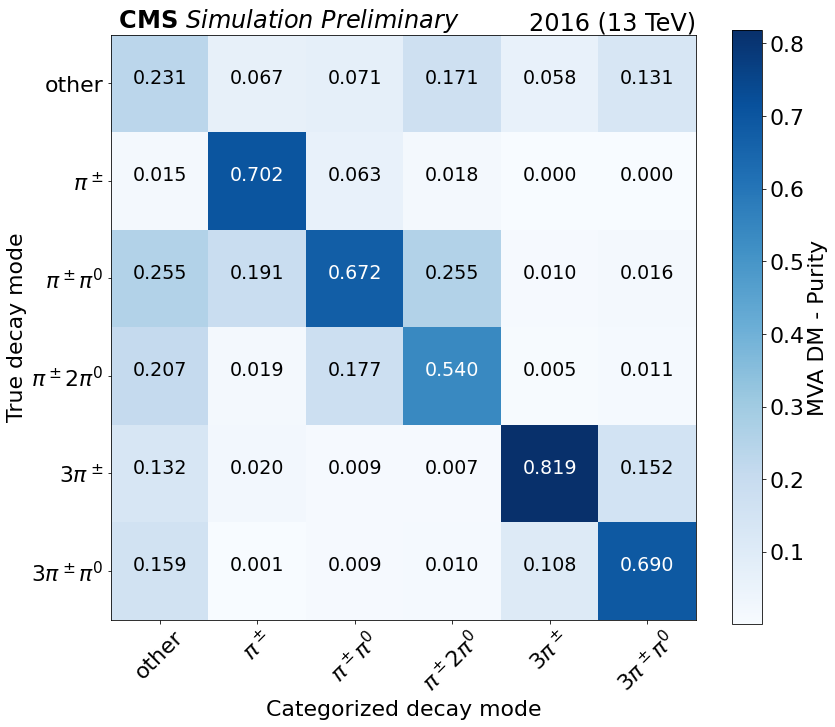

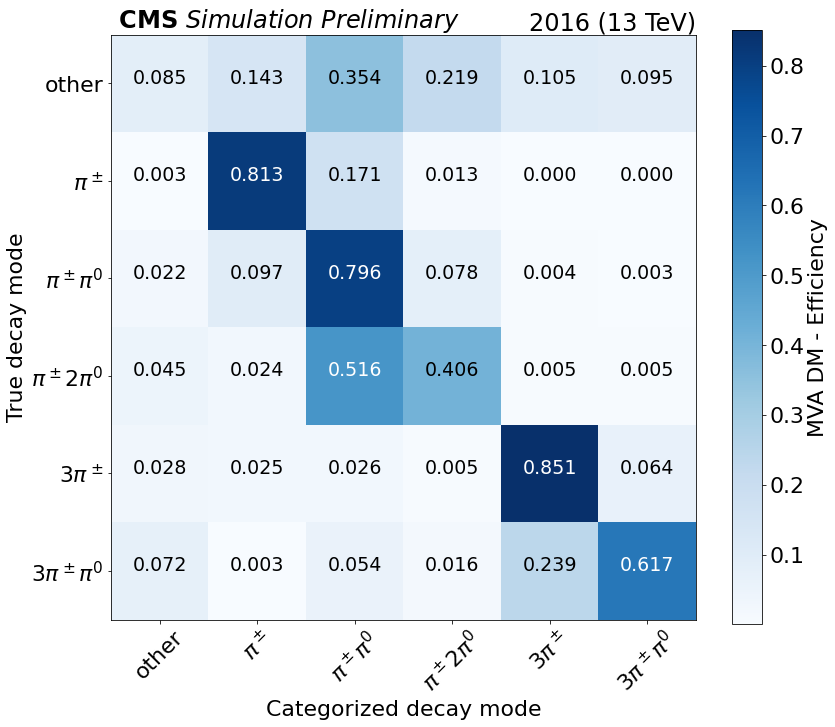

In [12]:
tree_2016= uproot.open("../Merged_ggH_VBF_HToTauTau_M-125_mt_2016.root")["ntuple"]
calc_conf_matrix(tree_2016, "2016", "MVA")

/tmp/ipykernel_513/2313971162.py:36: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]


Normalised purity confusion matrix
[[           nan 6.44916592e-02 9.90885487e-02            nan
  7.03012641e-02 1.42846281e-01]
 [           nan 5.38148422e-01 3.28137881e-02            nan
  1.10703202e-03 4.56215942e-04]
 [           nan 3.20561881e-01 5.82103811e-01            nan
  3.43369162e-02 5.77366620e-02]
 [           nan 5.91478323e-02 2.70811985e-01            nan
  1.70312618e-02 5.19579268e-02]
 [           nan 1.59027952e-02 6.20603576e-03            nan
  7.10411778e-01 1.58839184e-01]
 [           nan 1.74741105e-03 8.97583075e-03            nan
  1.66811748e-01 5.88163731e-01]]
Confusion matrix saved as purtiy_HPS_DM_2018
Normalised efficiency confusion matrix
Non-normalised confusion matrix
[[0.00000000e+00 1.97102049e-01 5.32436349e-01 0.00000000e+00
  1.53798385e-01 1.16663217e-01]
 [0.00000000e+00 9.01792098e-01 9.66757085e-02 0.00000000e+00
  1.32790067e-03 2.04292411e-04]
 [0.00000000e+00 2.31620364e-01 7.39472358e-01 0.00000000e+00
  1.77593556e-02 1.1147922

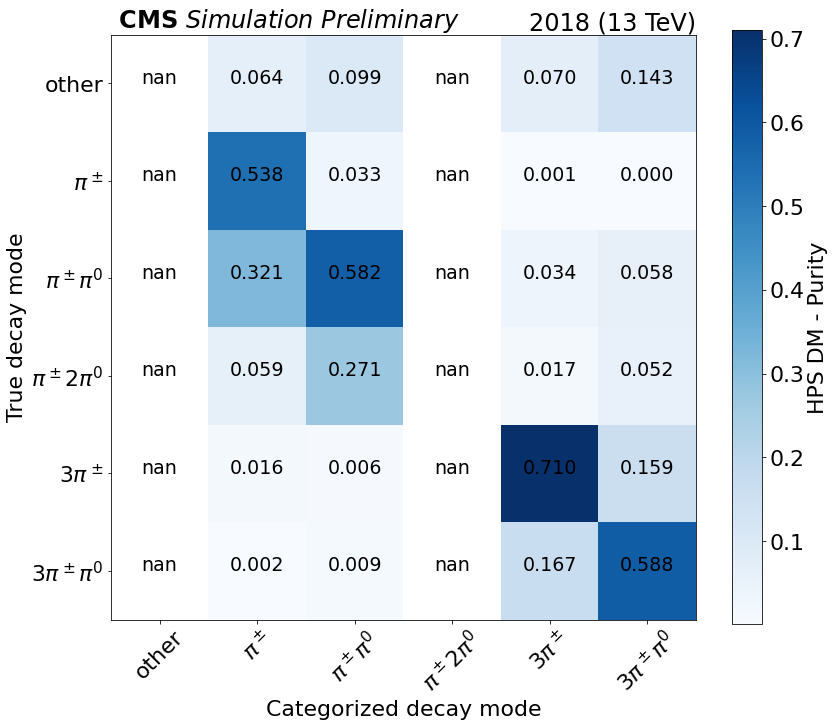

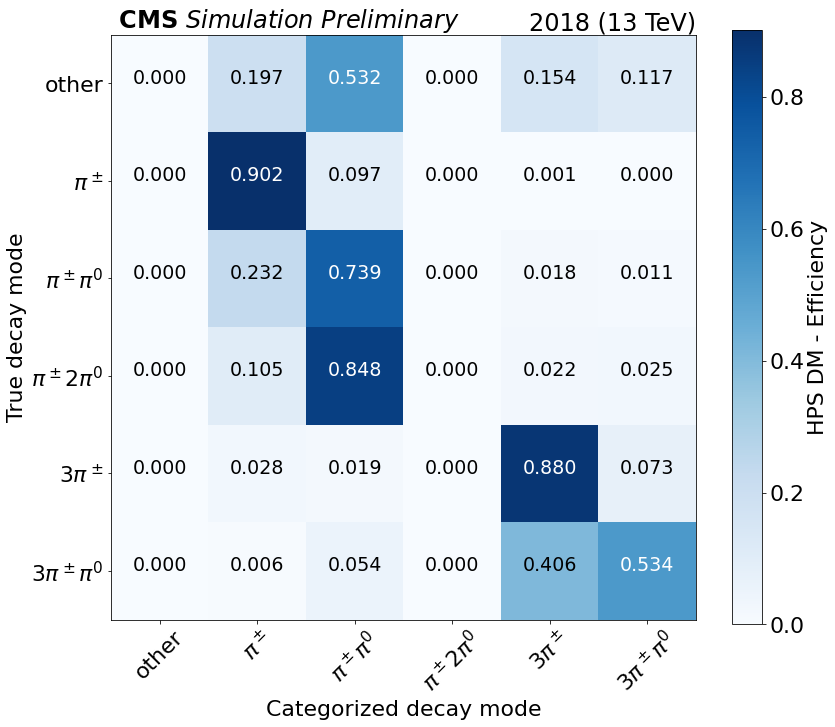

In [13]:
tree_2018= uproot.open("../Merged_ggH_VBF_HToTauTau_M-125_mt_2018.root")["ntuple"]
calc_conf_matrix(tree_2018, "2018", "HPS")